<a href="https://colab.research.google.com/github/nisaodabas/CNG483-Project2/blob/master/CNG483_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform, RandomUniform
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model  
from keras.utils import np_utils
import matplotlib.pyplot as plt
from google.colab import output
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Create  dataset from .txt file**

In [0]:
def createDataSet(path):
    df = pd.read_csv(path, sep='\n')
    data = np.array(df)

    #print(data)
    numAttr = 0
    rows = []
    for row in data:        
        found = row[0].find("@ATTRIBUTE")
        if(found != -1):
            numAttr += 1
        else:
            # ignore @ATTRIBUTE rows
            rows.append(row[0].split(","))

    # delete @DATA row
    rows = np.array(rows[1:])

    labels = rows[:, -1].astype('int')
    
    labels = np.array([x - 1 for x in labels])

    if(numAttr == 6):
        features = rows[:, :numAttr-1].astype('float')
    else:
        features = rows[:, :numAttr-1].astype('int')
        # define feature selection
        #fs = SelectKBest(score_func=f_classif, k=4000)
        # apply feature selection
        #features = fs.fit_transform(features, labels)
        

    return features, labels

### **Plot history graph of the model**

In [0]:
def plotHistory(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### **Texture Features - 0 Hidden Layer**

In [0]:
def model_textr_0(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    ## 0 - Hidden Layer NN ##

    model = Sequential()
    model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dropout(0.8))
        
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 48

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
        

### **Texture Features - 1 Hidden Layer**

In [0]:
def model_textr_1(X, y, X_test, y_test, dim):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    ## 1 - Hidden Layer NN ##
    
    model = Sequential()
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dropout(0.8))

    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.8))
        
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 48

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
    

### **Texture Features - 2 Hidden Layer**

In [0]:
def model_textr_2(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    ## 2 - Hidden Layer NN ##
    
    model = Sequential()
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.6))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    model.add(Dropout(0.6))
    
    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 48

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
    

### **Texture Features - 3 Hidden Layer**

In [0]:
def model_textr_3(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)
    
    ## 3 - Hidden Layer NN ##
    
    model = Sequential()
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    model.add(Dropout(0.5))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    model.add(Dropout(0.5))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
    

### **Geometric Features - 0 Hidden Layer**

In [0]:
def model_geo_0(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 0 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(4, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    
    numEpochs = 5000
    batches = 28 

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)
   
    

### **Geometric Features - 1 Hidden Layer**

In [0]:
def model_geo_1(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 1 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(8, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    #model.add(Dropout(0.2))

    model.add(Dense(5, activation='relu', kernel_initializer=RandomUniform(seed=1)))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64   

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Geometric Features - 2 Hidden Layer**

In [0]:
def model_geo_2(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 2 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(8, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(8, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Geometric Features - 3 Hidden Layer**

In [0]:
def model_geo_3(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 3 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(24, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(24, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 64

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batches, verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, batch_size=batches, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batches, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Texture & Geometric Features - 0 Hidden Layer**

In [0]:
def model_combined_0(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 0 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(12, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))
    model.add(Dropout(0.1))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    
    numEpochs = 5000
    batches = 36

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))

    plotHistory(history)

### **Texture & Geometric Features - 1 Hidden Layer**

In [0]:
def model_combined_1(X, y, X_test, y_test, dim):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 1 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))
    #model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu', kernel_initializer=RandomUniform(seed=1)))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    
    numEpochs = 5000
    batches = 26

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Texture & Geometric Features - 2 Hidden Layer**

In [0]:
def model_combined_2(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)

    # 2 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))
    #model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.00001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    
    numEpochs = 5000
    batches = 26

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Texture & Geometric Features - 3 Hidden Layer**

In [0]:
def model_combined_3(X, y, X_test, y_test, dim):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1)
    
    # 3 - Hidden Layer NN #
    
    model = Sequential()
    model.add(Dense(96, activation='relu', kernel_initializer=RandomUniform(seed=1), input_dim=dim))

    model.add(Dense(128, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    
    #model.add(Dropout(0.2))
    
    model.add(Dense(96, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))
    
    model.add(Dense(48, activation='relu', kernel_initializer=RandomUniform(seed=1)))
    #model.add(Dropout(0.2))

    model.add(Dense(3, activation='softmax'))

    # compile the model
    opt = RMSprop(learning_rate=0.000001, rho=0.9, momentum=0.0)
    #model.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    numEpochs = 5000
    batches = 128

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=numEpochs, batch_size=batches, verbose=0 , callbacks=[es])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train,verbose=0)
    _, validation_acc = model.evaluate(X_val, y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Validation: %.3f, Test: %.3f'  % (train_acc*100, validation_acc*100, test_acc*100))
    
    plotHistory(history)

### **Main**

In [0]:
if __name__ == "__main__":
    geometic_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TestingSet.txt"
    geometic_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisGeometicFeatures_TrainingSet.txt"

    texture_test_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TestingSet.txt"
    texture_train_path = "/content/drive/My Drive/CNG483-Project 2/IrisTextureFeatures_TrainingSet.txt"


    geo_x_train, geo_y_train = createDataSet(geometic_train_path)
    geo_x_test, geo_y_test = createDataSet(geometic_test_path)

    txtr_x_train, txtr_y_train = createDataSet(texture_train_path)
    txtr_x_test, txtr_y_test = createDataSet(texture_test_path)

    all_x_train = np.concatenate((txtr_x_train, geo_x_train), axis=1)
    all_x_test = np.concatenate((txtr_x_test, geo_x_test), axis=1)


### **Result: Texture - 0 Hidden Layer**

Epoch 1/5000
21/21 [==============================] - 0s 11ms/step - loss: 2.8920 - acc: 0.2582 - val_loss: 1.2434 - val_acc: 0.3605
Epoch 2/5000
21/21 [==============================] - 0s 8ms/step - loss: 2.0076 - acc: 0.3519 - val_loss: 1.0720 - val_acc: 0.4535
Epoch 3/5000
21/21 [==============================] - 0s 7ms/step - loss: 1.6744 - acc: 0.4023 - val_loss: 1.0162 - val_acc: 0.5233
Epoch 4/5000
21/21 [==============================] - 0s 7ms/step - loss: 1.4757 - acc: 0.4136 - val_loss: 0.9856 - val_acc: 0.4709
Epoch 5/5000
21/21 [==============================] - 0s 7ms/step - loss: 1.3698 - acc: 0.4527 - val_loss: 0.9647 - val_acc: 0.5000
Epoch 6/5000
21/21 [==============================] - 0s 7ms/step - loss: 1.2247 - acc: 0.4516 - val_loss: 0.9582 - val_acc: 0.5349
Epoch 7/5000
21/21 [==============================] - 0s 7ms/step - loss: 1.2149 - acc: 0.4815 - val_loss: 0.9542 - val_acc: 0.5291
Epoch 8/5000
21/21 [==============================] - 0s 7ms/step - loss: 1

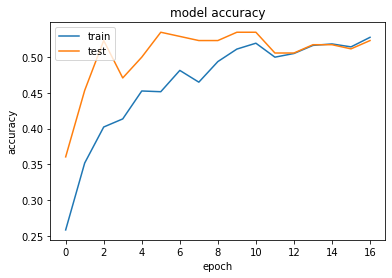

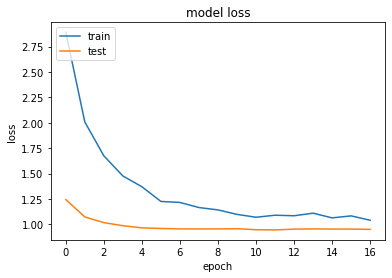

In [44]:
    model_textr_0(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Texture - 1 Hidden Layer**

Epoch 1/5000
21/21 [==============================] - 0s 12ms/step - loss: 1.4974 - acc: 0.3796 - val_loss: 1.0675 - val_acc: 0.3779
Epoch 2/5000
21/21 [==============================] - 0s 8ms/step - loss: 1.4278 - acc: 0.3169 - val_loss: 1.0632 - val_acc: 0.4070
Epoch 3/5000
21/21 [==============================] - 0s 8ms/step - loss: 1.3586 - acc: 0.3261 - val_loss: 1.0635 - val_acc: 0.4360
Epoch 4/5000
21/21 [==============================] - 0s 8ms/step - loss: 1.2813 - acc: 0.3652 - val_loss: 1.0677 - val_acc: 0.4360
Epoch 5/5000
21/21 [==============================] - 0s 8ms/step - loss: 1.2277 - acc: 0.3477 - val_loss: 1.0674 - val_acc: 0.4477
Epoch 6/5000
21/21 [==============================] - 0s 9ms/step - loss: 1.1834 - acc: 0.3611 - val_loss: 1.0704 - val_acc: 0.4360
Epoch 7/5000
21/21 [==============================] - 0s 9ms/step - loss: 1.1751 - acc: 0.3714 - val_loss: 1.0723 - val_acc: 0.4419
Epoch 00007: early stopping
Train: 46.914, Validation: 44.186, Test: 44.079

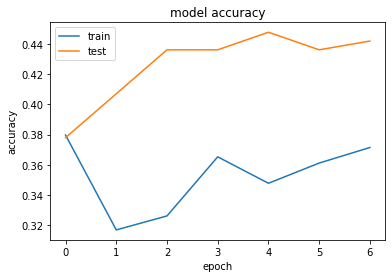

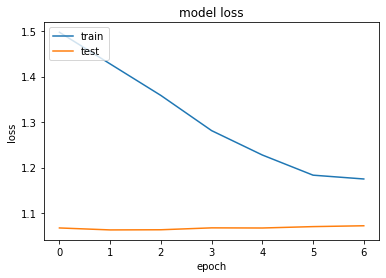

In [45]:
    model_textr_1(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Texture - 2 Hidden Layer**

Epoch 1/5000
21/21 [==============================] - 0s 12ms/step - loss: 1.0753 - acc: 0.4475 - val_loss: 1.0767 - val_acc: 0.5116
Epoch 2/5000
21/21 [==============================] - 0s 9ms/step - loss: 1.0652 - acc: 0.4918 - val_loss: 1.0677 - val_acc: 0.5581
Epoch 3/5000
21/21 [==============================] - 0s 9ms/step - loss: 1.0582 - acc: 0.4733 - val_loss: 1.0585 - val_acc: 0.5640
Epoch 4/5000
21/21 [==============================] - 0s 9ms/step - loss: 1.0508 - acc: 0.4835 - val_loss: 1.0488 - val_acc: 0.5698
Epoch 5/5000
21/21 [==============================] - 0s 8ms/step - loss: 1.0419 - acc: 0.4815 - val_loss: 1.0385 - val_acc: 0.5756
Epoch 6/5000
21/21 [==============================] - 0s 8ms/step - loss: 1.0313 - acc: 0.4733 - val_loss: 1.0274 - val_acc: 0.5756
Epoch 7/5000
21/21 [==============================] - 0s 8ms/step - loss: 1.0252 - acc: 0.5051 - val_loss: 1.0183 - val_acc: 0.5756
Epoch 8/5000
21/21 [==============================] - 0s 8ms/step - loss: 1

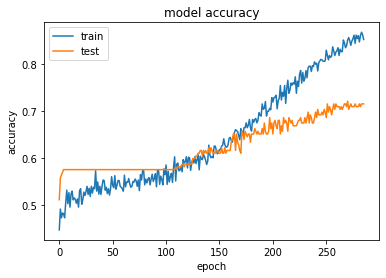

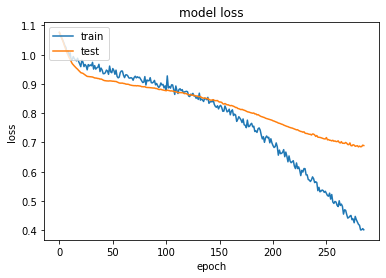

In [46]:
    model_textr_2(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Texture - 3 Hidden Layer**

Epoch 1/5000
16/16 [==============================] - 0s 15ms/step - loss: 1.0997 - acc: 0.3066 - val_loss: 1.0983 - val_acc: 0.4070
Epoch 2/5000
16/16 [==============================] - 0s 10ms/step - loss: 1.0991 - acc: 0.3220 - val_loss: 1.0978 - val_acc: 0.4477
Epoch 3/5000
16/16 [==============================] - 0s 10ms/step - loss: 1.0985 - acc: 0.3426 - val_loss: 1.0972 - val_acc: 0.5116
Epoch 4/5000
16/16 [==============================] - 0s 10ms/step - loss: 1.0976 - acc: 0.3776 - val_loss: 1.0967 - val_acc: 0.5523
Epoch 5/5000
16/16 [==============================] - 0s 10ms/step - loss: 1.0972 - acc: 0.3827 - val_loss: 1.0961 - val_acc: 0.5698
Epoch 6/5000
16/16 [==============================] - 0s 10ms/step - loss: 1.0963 - acc: 0.3776 - val_loss: 1.0954 - val_acc: 0.5756
Epoch 7/5000
16/16 [==============================] - 0s 10ms/step - loss: 1.0959 - acc: 0.3992 - val_loss: 1.0948 - val_acc: 0.5640
Epoch 8/5000
16/16 [==============================] - 0s 10ms/step - 

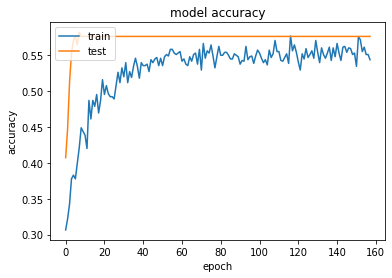

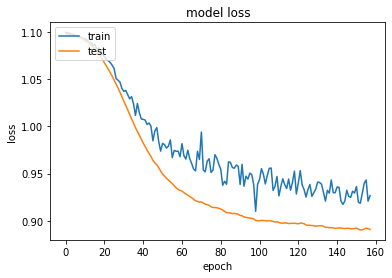

In [47]:
    model_textr_3(txtr_x_train, txtr_y_train, txtr_x_test, txtr_y_test, txtr_x_train.shape[1]) 


### **Result: Geometric - 0 Hidden Layer**

Streaming output truncated to the last 5000 lines.
Epoch 2502/5000
35/35 [==============================] - 0s 2ms/step - loss: 0.8983 - acc: 0.5730 - val_loss: 0.8956 - val_acc: 0.5756
Epoch 2503/5000
35/35 [==============================] - 0s 2ms/step - loss: 0.8983 - acc: 0.5730 - val_loss: 0.8956 - val_acc: 0.5756
Epoch 2504/5000
35/35 [==============================] - 0s 2ms/step - loss: 0.8982 - acc: 0.5730 - val_loss: 0.8955 - val_acc: 0.5756
Epoch 2505/5000
35/35 [==============================] - 0s 2ms/step - loss: 0.8982 - acc: 0.5730 - val_loss: 0.8955 - val_acc: 0.5756
Epoch 2506/5000
35/35 [==============================] - 0s 2ms/step - loss: 0.8982 - acc: 0.5730 - val_loss: 0.8955 - val_acc: 0.5756
Epoch 2507/5000
35/35 [==============================] - 0s 2ms/step - loss: 0.8982 - acc: 0.5730 - val_loss: 0.8955 - val_acc: 0.5756
Epoch 2508/5000
35/35 [==============================] - 0s 2ms/step - loss: 0.8982 - acc: 0.5730 - val_loss: 0.8955 - val_acc: 0.5756
Epoc

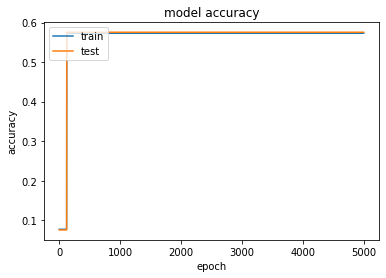

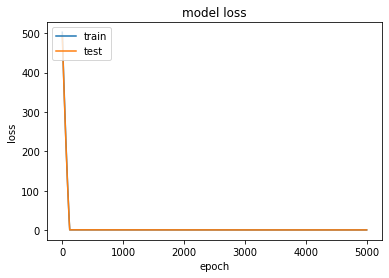

In [48]:
    model_geo_0(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Geometric - 1 Hidden Layer**

Epoch 1/5000
16/16 [==============================] - 0s 7ms/step - loss: 16.5198 - acc: 0.5730 - val_loss: 15.9878 - val_acc: 0.5756
Epoch 2/5000
16/16 [==============================] - 0s 3ms/step - loss: 15.9895 - acc: 0.5730 - val_loss: 15.5155 - val_acc: 0.5756
Epoch 3/5000
16/16 [==============================] - 0s 3ms/step - loss: 15.5318 - acc: 0.5730 - val_loss: 15.0898 - val_acc: 0.5756
Epoch 4/5000
16/16 [==============================] - 0s 3ms/step - loss: 15.0959 - acc: 0.5730 - val_loss: 14.6533 - val_acc: 0.5756
Epoch 5/5000
16/16 [==============================] - 0s 3ms/step - loss: 14.6492 - acc: 0.5730 - val_loss: 14.2048 - val_acc: 0.5756
Epoch 6/5000
16/16 [==============================] - 0s 3ms/step - loss: 14.2065 - acc: 0.5730 - val_loss: 13.7804 - val_acc: 0.5756
Epoch 7/5000
16/16 [==============================] - 0s 3ms/step - loss: 13.7708 - acc: 0.5730 - val_loss: 13.3549 - val_acc: 0.5756
Epoch 8/5000
16/16 [==============================] - 0s 3ms/s

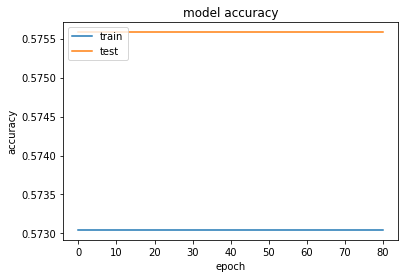

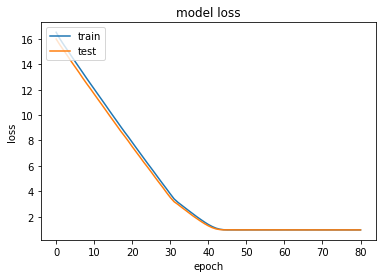

In [49]:
    model_geo_1(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Geometric - 2 Hidden Layer**

Epoch 1/5000
16/16 [==============================] - 0s 8ms/step - loss: 0.8872 - acc: 0.5730 - val_loss: 0.8827 - val_acc: 0.5756
Epoch 2/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8855 - acc: 0.5730 - val_loss: 0.8821 - val_acc: 0.5756
Epoch 3/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8854 - acc: 0.5730 - val_loss: 0.8819 - val_acc: 0.5756
Epoch 4/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8853 - acc: 0.5730 - val_loss: 0.8824 - val_acc: 0.5756
Epoch 5/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8850 - acc: 0.5730 - val_loss: 0.8827 - val_acc: 0.5756
Epoch 6/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8856 - acc: 0.5730 - val_loss: 0.8837 - val_acc: 0.5756
Epoch 7/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8855 - acc: 0.5730 - val_loss: 0.8844 - val_acc: 0.5756
Epoch 8/5000
16/16 [==============================] - 0s 4ms/step - loss: 0.

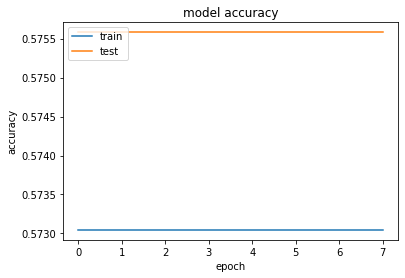

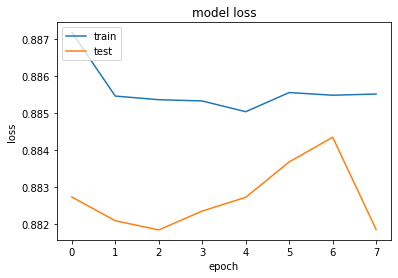

In [50]:
    model_geo_2(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Geometric - 3 Hidden Layer**

Epoch 1/5000
16/16 [==============================] - 0s 8ms/step - loss: 1.1079 - acc: 0.3498 - val_loss: 1.0051 - val_acc: 0.3488
Epoch 2/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.9772 - acc: 0.3498 - val_loss: 0.9460 - val_acc: 0.3488
Epoch 3/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.9314 - acc: 0.5309 - val_loss: 0.9130 - val_acc: 0.5756
Epoch 4/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.9046 - acc: 0.5730 - val_loss: 0.8942 - val_acc: 0.5756
Epoch 5/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8927 - acc: 0.5730 - val_loss: 0.8869 - val_acc: 0.5756
Epoch 6/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8891 - acc: 0.5730 - val_loss: 0.8881 - val_acc: 0.5756
Epoch 7/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.8892 - acc: 0.5730 - val_loss: 0.8839 - val_acc: 0.5756
Epoch 8/5000
16/16 [==============================] - 0s 3ms/step - loss: 0.

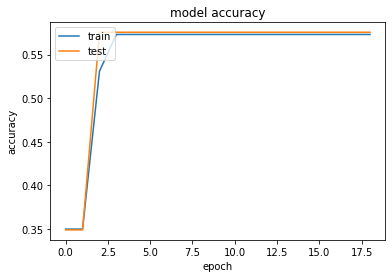

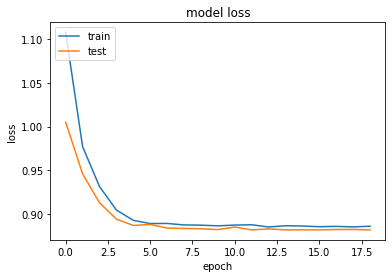

In [51]:
    model_geo_3(geo_x_train, geo_y_train, geo_x_test, geo_y_test, geo_x_train.shape[1])
    

### **Result: Texture & Geometric - 0 Hidden Layer**

Epoch 1/5000
27/27 [==============================] - 0s 14ms/step - loss: 458.8300 - acc: 0.3971 - val_loss: 323.8265 - val_acc: 0.3488
Epoch 2/5000
27/27 [==============================] - 0s 5ms/step - loss: 460.0840 - acc: 0.3940 - val_loss: 307.1601 - val_acc: 0.3488
Epoch 3/5000
27/27 [==============================] - 0s 4ms/step - loss: 453.7971 - acc: 0.3735 - val_loss: 290.4892 - val_acc: 0.3488
Epoch 4/5000
27/27 [==============================] - 0s 4ms/step - loss: 405.8480 - acc: 0.3930 - val_loss: 274.3708 - val_acc: 0.3488
Epoch 5/5000
27/27 [==============================] - 0s 5ms/step - loss: 399.2179 - acc: 0.3992 - val_loss: 257.9418 - val_acc: 0.3488
Epoch 6/5000
27/27 [==============================] - 0s 4ms/step - loss: 395.2825 - acc: 0.3755 - val_loss: 241.6237 - val_acc: 0.3488
Epoch 7/5000
27/27 [==============================] - 0s 5ms/step - loss: 404.5967 - acc: 0.3642 - val_loss: 225.4402 - val_acc: 0.3488
Epoch 8/5000
27/27 [===========================

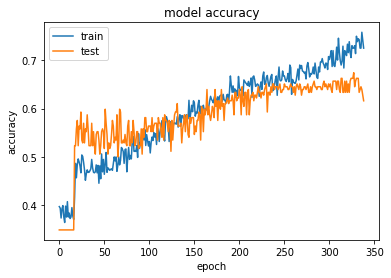

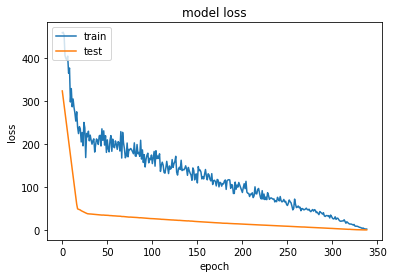

In [52]:
    model_combined_0(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

### **Result: Texture & Geometric - 1 Hidden Layer**

Epoch 1/5000
38/38 [==============================] - 0s 6ms/step - loss: 12.4793 - acc: 0.3498 - val_loss: 9.2520 - val_acc: 0.3488
Epoch 2/5000
38/38 [==============================] - 0s 5ms/step - loss: 6.9289 - acc: 0.3498 - val_loss: 4.1137 - val_acc: 0.3488
Epoch 3/5000
38/38 [==============================] - 0s 5ms/step - loss: 2.8069 - acc: 0.4249 - val_loss: 2.1487 - val_acc: 0.5756
Epoch 4/5000
38/38 [==============================] - 0s 5ms/step - loss: 2.1420 - acc: 0.5730 - val_loss: 1.9769 - val_acc: 0.5756
Epoch 5/5000
38/38 [==============================] - 0s 5ms/step - loss: 1.9594 - acc: 0.5730 - val_loss: 1.8192 - val_acc: 0.5756
Epoch 6/5000
38/38 [==============================] - 0s 5ms/step - loss: 1.7767 - acc: 0.5730 - val_loss: 1.6230 - val_acc: 0.5756
Epoch 7/5000
38/38 [==============================] - 0s 5ms/step - loss: 1.5802 - acc: 0.5730 - val_loss: 1.4372 - val_acc: 0.5756
Epoch 8/5000
38/38 [==============================] - 0s 5ms/step - loss: 1

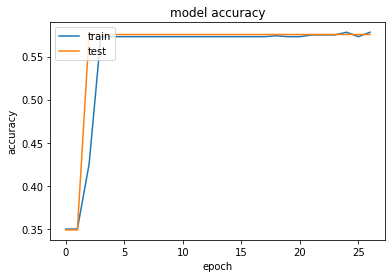

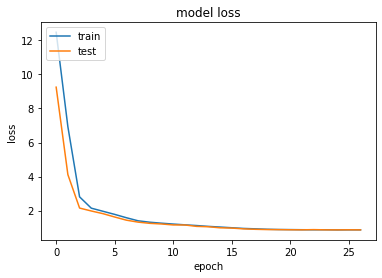

In [53]:
    model_combined_1(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

### **Result: Texture & Geometric - 2 Hidden Layer**

Epoch 1/5000
38/38 [==============================] - 1s 14ms/step - loss: 3.5003 - acc: 0.4146 - val_loss: 1.6893 - val_acc: 0.5756
Epoch 2/5000
38/38 [==============================] - 0s 7ms/step - loss: 1.4188 - acc: 0.5586 - val_loss: 1.0637 - val_acc: 0.3837
Epoch 3/5000
38/38 [==============================] - 0s 7ms/step - loss: 0.9262 - acc: 0.5638 - val_loss: 1.0258 - val_acc: 0.3488
Epoch 4/5000
38/38 [==============================] - 0s 7ms/step - loss: 0.9030 - acc: 0.5535 - val_loss: 0.9588 - val_acc: 0.3488
Epoch 5/5000
38/38 [==============================] - 0s 7ms/step - loss: 0.8998 - acc: 0.5566 - val_loss: 0.8850 - val_acc: 0.5756
Epoch 6/5000
38/38 [==============================] - 0s 7ms/step - loss: 0.9023 - acc: 0.5576 - val_loss: 0.8875 - val_acc: 0.5756
Epoch 7/5000
38/38 [==============================] - 0s 7ms/step - loss: 0.8965 - acc: 0.5720 - val_loss: 0.8844 - val_acc: 0.5756
Epoch 8/5000
38/38 [==============================] - 0s 7ms/step - loss: 0

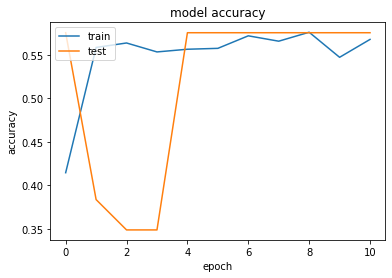

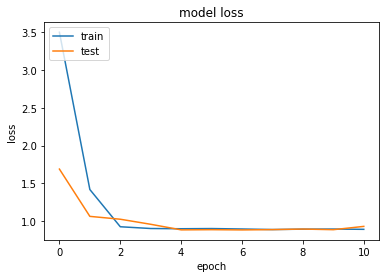

In [54]:
    model_combined_2(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

### **Result: Texture & Geometric - 3 Hidden Layer**

Epoch 1/5000
8/8 [==============================] - 0s 28ms/step - loss: 4.0489 - acc: 0.5730 - val_loss: 3.9012 - val_acc: 0.5756
Epoch 2/5000
8/8 [==============================] - 0s 19ms/step - loss: 3.8970 - acc: 0.5730 - val_loss: 3.7767 - val_acc: 0.5756
Epoch 3/5000
8/8 [==============================] - 0s 18ms/step - loss: 3.7781 - acc: 0.5730 - val_loss: 3.6652 - val_acc: 0.5756
Epoch 4/5000
8/8 [==============================] - 0s 19ms/step - loss: 3.6678 - acc: 0.5730 - val_loss: 3.5598 - val_acc: 0.5756
Epoch 5/5000
8/8 [==============================] - 0s 18ms/step - loss: 3.5619 - acc: 0.5730 - val_loss: 3.4570 - val_acc: 0.5756
Epoch 6/5000
8/8 [==============================] - 0s 18ms/step - loss: 3.4595 - acc: 0.5730 - val_loss: 3.3546 - val_acc: 0.5756
Epoch 7/5000
8/8 [==============================] - 0s 20ms/step - loss: 3.3539 - acc: 0.5730 - val_loss: 3.2505 - val_acc: 0.5756
Epoch 8/5000
8/8 [==============================] - 0s 19ms/step - loss: 3.2503 - a

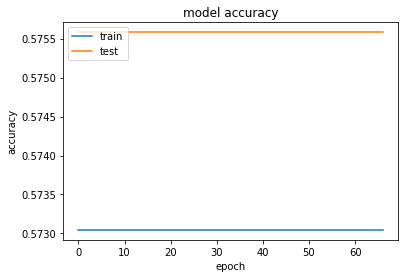

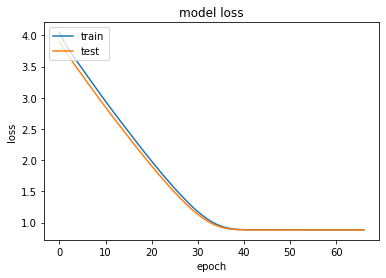

In [55]:
    model_combined_3(all_x_train, txtr_y_train, all_x_test, txtr_y_test, all_x_train.shape[1])
    

In [56]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

KeyboardInterrupt: ignored